In [ ]:

# Copyright 2024.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

#Prerequisites
Install libraries for conversion.

In [ ]:
!pip install -r https://github.com/google-ai-edge/ai-edge-torch/releases/download/v0.1.1/requirements.txt
!pip install mediapipe
!pip install ai-edge-torch==0.1.1

In [ ]:
!pip install validators matplotlib
#For metadata writer
!pip install tflite-support #not nightly

In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch import nn
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import validators
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [ ]:
model18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model18.eval()

In [3]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-05-26 05:40:25--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-05-26 05:40:25 (97.9 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



<class 'PIL.JpegImagePlugin.JpegImageFile'>


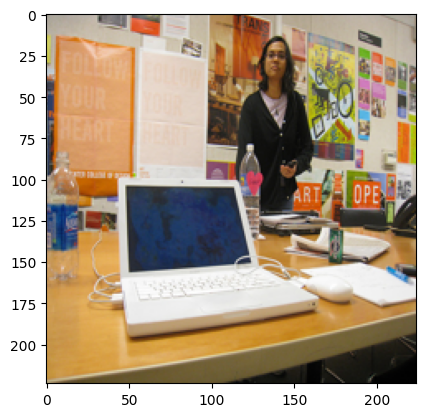

<class 'numpy.ndarray'>
(1, 224, 224, 3)


In [5]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

pil_image = Image.open(requests.get(uris[0], stream=True).raw)
print(type(pil_image))

resized_image = pil_image.resize((224, 224))
plt.imshow(resized_image)
plt.show()

# Apply the transformation
# Convert the PIL image to a NumPy array and expand dimensions
numpy_image = np.array(resized_image)
numpy_image_same = np.expand_dims(numpy_image, axis=0)

# Check the type and shape of the tensor
print(type(numpy_image_same))
print(numpy_image_same.shape)

#Wrapper class to use when converting

Before converting the PyTorch model to TFLite, you will need to take an extra step to match it to the format expected by MediaPipe (MP) Tasks. Here are the necessary adjustments:

1. MediaPipe Tasks require channel-last images (BHWC) while PyTorch uses channel-first (BCHW).

2. For the Image Classification Task, MediaPipe requires an additional sigmoid layer on classification logits.



In [6]:
class ImageClassificationModelWrapper(nn.Module):

  def __init__(self, image_classification_model):
    super().__init__()
    self.model = image_classification_model

  def forward(self, image: torch.Tensor):
    # BHWC -> BCHW.
    image = image.permute(0,3,1,2)
    # Normalize inputs [0,1]
    input_batch = image / 255.0
    logits = self.model(input_batch)
    logits = torch.nn.functional.softmax(logits[0], dim=0)

    return logits

In [7]:
wrapped_pt_model = ImageClassificationModelWrapper(
model18).eval()

In [8]:
import ai_edge_torch

sample_args = (torch.rand((1, 224, 224, 3)),)
edge_model = ai_edge_torch.convert(wrapped_pt_model, sample_args)

In [9]:
edge_model.export('resnet18.tflite')

#Check .tflite file with the Interpreter API

In [ ]:
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/resnet18.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

input_data = np.array(numpy_image_same, dtype=np.float32)

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data

In [11]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(torch.from_numpy(output_data), 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

laptop 0.3680455684661865
notebook 0.21134474873542786
screen 0.09741917997598648
desk 0.08575554192066193
monitor 0.05525420978665352


Visualize with model explorer

In [ ]:
!pip install ai-edge-model-explorer

In [14]:
import model_explorer
model_explorer.visualize('/content/resnet18.tflite')

ℹ️ Please re-run the cell in each new session

Loading extensions...
Loaded 8 extensions:
 - TFLite adapter (Flatbuffer)
 - TFLite adapter (MLIR)
 - TF adapter (MLIR)
 - TF adapter (direct)
 - GraphDef adapter
 - Pytorch adapter (exported program)
 - MLIR adapter
 - JSON adapter


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "/content/resnet18.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "/content/imagenet_classes.txt"
_SAVE_TO_PATH = "/content/resnet18_meta.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 0.0
_INPUT_NORM_STD = 1.0

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

Download resnet18.rflite file and place it inside the assets folder of the MediaPipe classification app.
https://github.com/google-ai-edge/mediapipe-samples/tree/main/examples/image_classification/android